## 🤖🖇️Retriever & ReRanker Ensemble Train/Validation
### **[Model Straegy Summary]**
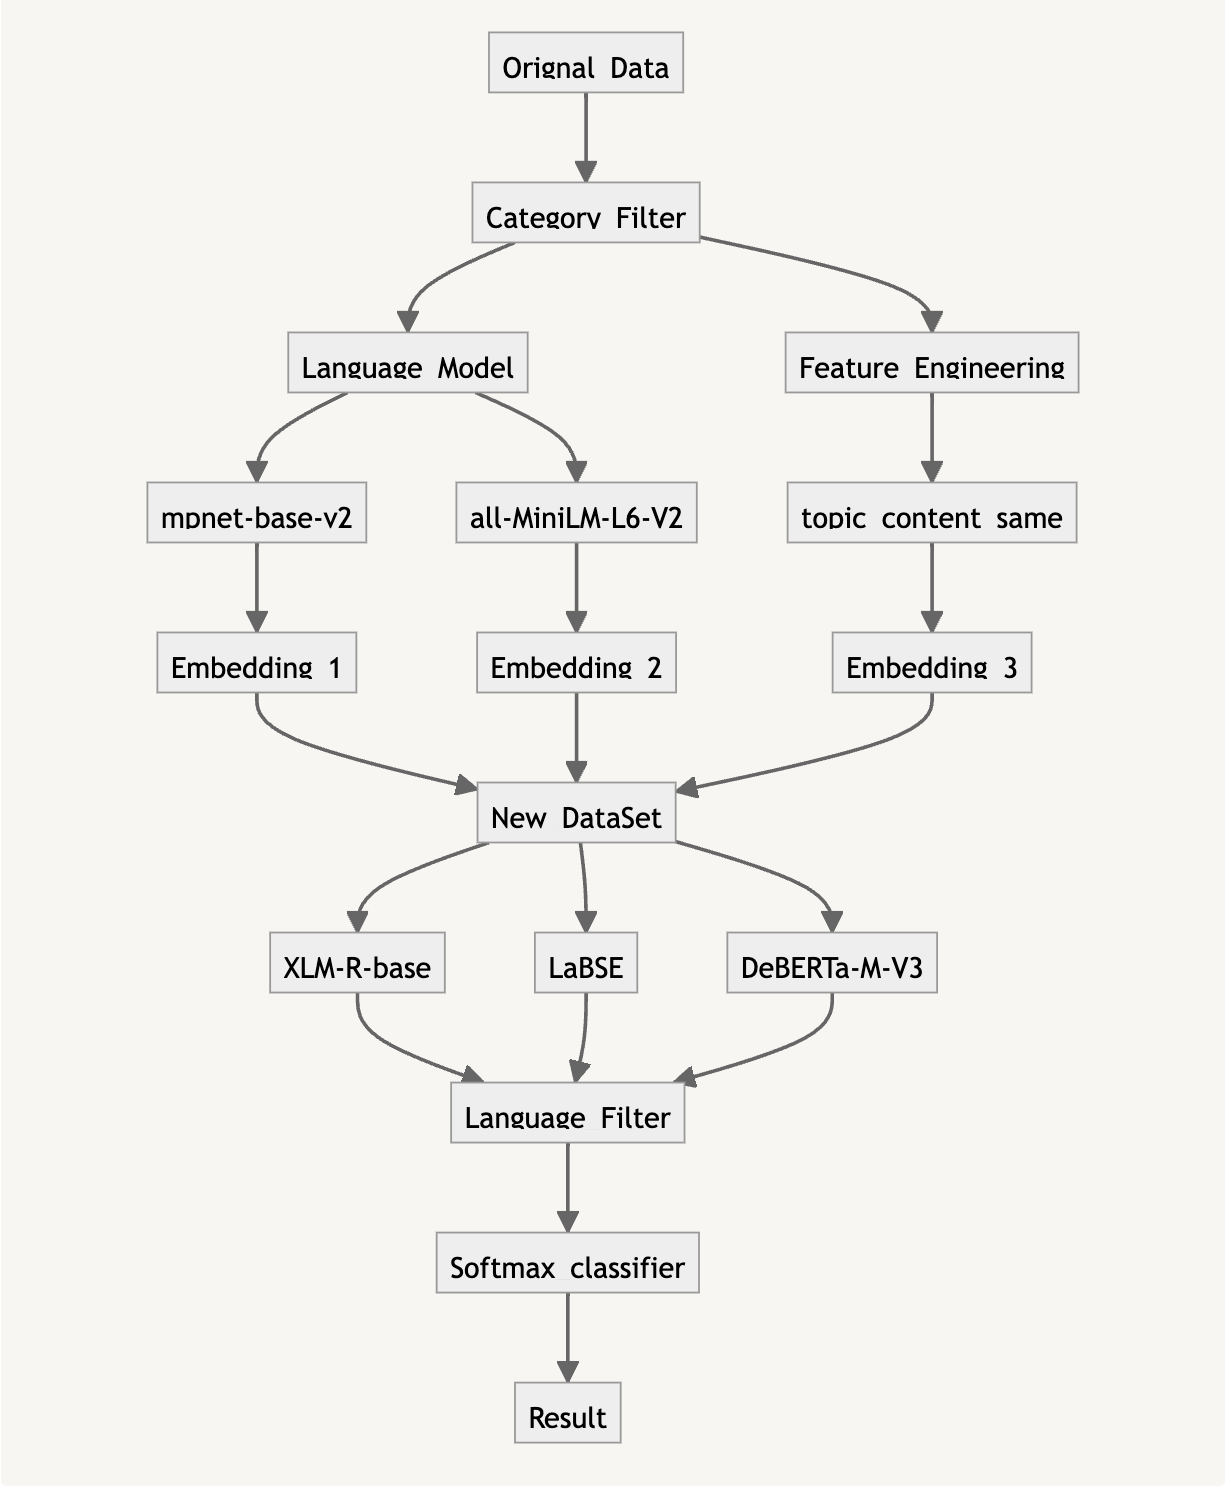

In [1]:
import wandb
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import tokenizers, transformers
import os, sys, gc, time, random, warnings, math

from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.utils.checkpoint import checkpoint

from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import get_cosine_schedule_with_warmup, DataCollatorWithPadding
from sklearn.model_selection import StratifiedGroupKFold
from tqdm.auto import tqdm
import cupy as cp
from cuml.metrics import pairwise_distances
from cuml.neighbors import NearestNeighbors
from kaggle_secrets import UserSecretsClient
warnings.filterwarnings("ignore")
%env TOKENIZERS_PARALLELISM=false
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

env: TOKENIZERS_PARALLELISM=false


In [2]:
# WandB Login => Copy API Key
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("wandb")

!wandb login $secret_value_0

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [3]:
""" Train Configuration Class """
class CFG2:
    wandb, train, competition, seed = True, True, 'LECR', 42
    device, gpu_id = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 0
    retriever = '/kaggle/input/m-mpnet-lecr-retrieverlm-stage1-fine-tune/paraphrase-multilingual-mpnet-base-v2-exp_fold0_epochs10' # Stage 1 Model
    retriever_tokenizer = AutoTokenizer.from_pretrained(retriever)
    pooling = 'attention' # options: attention, mean, weightedlayer, concat
    top_n = 50 # for KNN
    max_len = 256
    n_fold = 5
    loss_fn = 'BCE' # options: BCE, RMSE
    epochs = 5
    batch_size = 512
    optimizer = 'AdamW' # options: SWA, AdamW
    weight_decay = 1e-6
    scheduler = 'cosine' # options: cosine, linear
    num_cycles = 0.5
    warmup_ratio = 0.1
    batch_scheduler = True
    encoder_lr = 1e-5
    decoder_lr = 1e-5
    min_lr = 1e-6
    max_grad_norm = 10 # clip_grad_norm
    gradient_checkpointing = True
    num_workers = 4
    amp_scaler = True
    eps = 1e-6
    betas = (0.9, 0.999)
    llrd = True
    layerwise_lr = 5e-5
    layerwise_lr_decay = 0.9
    layerwise_weight_decay = 0.01
    layerwise_adam_epsilon = 1e-6
    layerwise_use_bertadam = False
    reinit = False
    init_weight = 'normal'
    reinit_n = 1 # Setting Re-Init Encoder Block Count Value    

# class CFG2:
#     wandb, train, competition, seed = True, True, 'LECR', 42
#     device, gpu_id = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 0
#     # mode
#     retriever = '/kaggle/input/m-mpnet-lecr-retrieverlm-stage1-fine-tune/paraphrase-multilingual-mpnet-base-v2-exp_fold0_epochs10' # Stage 1 Model
#     # retriever = 'sentence-transformers/all-MiniLM-L12-v2' # Bigger Model
#     # tokenizer
#     retriever_tokenizer = AutoTokenizer.from_pretrained(retriever)
#     # pooling
#     pooling = 'attention' # options: attention, mean, weightedlayer, concat
#     # Train/Validation
#     top_n = 50 # for KNN
#     max_len = 256
#     n_fold = 5
#     loss_fn = 'BCE' # options: BCE, RMSE
#     epochs = 5
#     batch_size = 512
#     optimizer = 'AdamW' # options: SWA, AdamW
#     weight_decay = 1e-6
#     scheduler = 'cosine' # options: cosine, linear
#     num_cycles = 0.5
# #    num_warmup_steps = 0
#     warmup_ratio = 0.1
#     batch_scheduler = True
#     encoder_lr = 1e-5
#     decoder_lr = 1e-5
#     min_lr = 1e-6
#     max_grad_norm = 10 # clip_grad_norm
#     gradient_checkpointing = True
#     num_workers = 4
#     amp_scaler = True
#     eps = 1e-6
#     betas = (0.9, 0.999)
#     # LLRD
#     llrd = True
#     layerwise_lr = 5e-5
#     layerwise_lr_decay = 0.9
#     layerwise_weight_decay = 0.01
#     layerwise_adam_epsilon = 1e-6
#     layerwise_use_bertadam = False
#     #re-init_weight
#     reinit = False
#     init_weight = 'normal'
#     reinit_n = 1 # Setting Re-Init Encoder Block Count Value    
    
# class CFG3:
#     wandb, train, competition, seed = True, True, 'LECR', 42
#     device, gpu_id = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 0
#     # model
#     retriever = 'sentence-transformers/all-MiniLM-L12-v2' # Stage 1 Model
#     retriever_tokenizer = AutoTokenizer.from_pretrained(retriever)
#     pooling = 'attention' # options: attention, mean, weightedlayer, concat
#     # Train/Validation
#     top_n = 20 # for KNN
#     max_len = 512
#     loss_fn = 'BCE' # options: BCE, RMSE
#     epochs = 5
#     batch_size = 32
#     num_workers = 4

# class CFG4:
#     wandb, train, competition, seed = True, True, 'LECR', 42
#     device, gpu_id = torch.device('cuda' if torch.cuda.is_available() else 'cpu'), 0
#     # model
#     retriever = 'sentence-transformers/LaBSE' # Stage 1 Model
#     retriever_tokenizer = AutoTokenizer.from_pretrained(retriever)
#     pooling = 'attention' # options: attention, mean, weightedlayer, concat
#     # Train/Validation
#     top_n = 20 # for KNN
#     max_len = 512
#     loss_fn = 'BCE' # options: BCE, RMSE
#     epochs = 5
#     batch_size = 32
#     num_workers = 4

In [4]:
""" Configuration class to dict """
def class2dict(f):
    return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

In [5]:
""" pytorch reproducibility functions """
def all_type_seed(CFG):
    os.environ['PYTHONHASHSEED'] = str(CFG.seed) # python Seed 
    random.seed(CFG.seed) # random module Seed
    np.random.seed(CFG.seed) # numpy module Seed
    torch.manual_seed(CFG.seed)

    torch.manual_seed(CFG.seed) # Pytorch CPU Random Seed Maker 
    torch.cuda.manual_seed(CFG.seed) # Pytorch GPU Random Seed Maker 
    torch.cuda.manual_seed_all(CFG.seed) # Pytorch Multi Core GPU Random Seed Maker 

    torch.backends.cudnn.deterministic = True 
    torch.backends.cudnn.benchmark = False 
    torch.backends.cudnn.enabled = False
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() %2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
all_type_seed(CFG2)    
g = torch.Generator()
g.manual_seed(0)

In [6]:
""" Get Ancestor & Parent Topic (Topic Tree) """ 

class Topic:
    """
    Get Topic Tree, source code from competition host
    Refenence:
        https://www.kaggle.com/code/jamiealexandre/tips-and-recommendations-from-hosts
    """
    def __init__(self, topic_id):
        self.id = topic_id

    @property
    def parent(self):
        parent_id = topics_df.loc[self.id].parent
        if pd.isna(parent_id):
            return None
        else:
            return Topic(parent_id)

    @property
    def ancestors(self):
        ancestors = []
        parent = self.parent
        while parent is not None:
            ancestors.append(parent)
            parent = parent.parent
        return ancestors

    @property
    def siblings(self):
        if not self.parent:
            return []
        else:
            return [topic for topic in self.parent.children if topic != self]

    @property
    def content(self):
        if self.id in correlations_df.index:
            return [ContentItem(content_id) for content_id in correlations_df.loc[self.id].content_ids.split()]
        else:
            return tuple([]) if self.has_content else []

    def get_breadcrumbs(self, separator=" ", include_self=False, include_root=True):
        ancestors = self.ancestors
        if include_self:
            ancestors = [self] + ancestors
        if not include_root:
            ancestors = ancestors[:-1]
        return separator.join(reversed([a.title for a in ancestors]))

    @property
    def children(self):
        return [Topic(child_id) for child_id in topics_df[topics_df.parent == self.id].index]

    def subtree_markdown(self, depth=0):
        markdown = "  " * depth + "- " + self.title + "\n"
        for child in self.children:
            markdown += child.subtree_markdown(depth=depth + 1)
        for content in self.content:
            markdown += ("  " * (depth + 1) + "- " + "[" + content.kind.title() + "] " + content.title) + "\n"
        return markdown

    def __eq__(self, other):
        if not isinstance(other, Topic):
            return False
        return self.id == other.id

    def __getattr__(self, name):
        return topics_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<Topic(id={self.id}, title=\"{self.title}\")>"


class ContentItem:
    def __init__(self, content_id):
        self.id = content_id

    @property
    def topics(self):
        return [Topic(topic_id) for topic_id in topics_df.loc[correlations_df[correlations_df.content_ids.str.contains(self.id)].index].index]

    def __getattr__(self, name):
        return content_df.loc[self.id][name]

    def __str__(self):
        return self.title
    
    def __repr__(self):
        return f"<ContentItem(id={self.id}, title=\"{self.title}\")>"

    def __eq__(self, other):
        if not isinstance(other, ContentItem):
            return False
        return self.id == other.id

    def get_all_breadcrumbs(self, separator=" >> ", include_root=True):
        breadcrumbs = []
        for topic in self.topics:
            new_breadcrumb = topic.get_breadcrumbs(separator=separator, include_root=include_root)
            if new_breadcrumb:
                new_breadcrumb = new_breadcrumb + separator + self.title
            else:
                new_breadcrumb = self.title
            breadcrumbs.append(new_breadcrumb)
        return breadcrumbs

In [7]:
"""
Make New DataFrame for Re-Ranker Model:
    Make prompt for Sentence Transformers
    Topic Dataset Prompt:
        1) shape
            - title + special token + description + special token + context(topic tree)
        2) remove category == source data

    Content Dataset Prompt:
        1) shape
            - title + special token + description or text + special token
"""
data_path = '/kaggle/input/learning-equality-curriculum-recommendations/'
topics_df = pd.read_csv(data_path + 'topics.csv')
content_df = pd.read_csv(data_path + 'content.csv')
correlations_df = pd.read_csv('/kaggle/input/minilm-lecr-retrieverlm-stage-1-fine-tune/all-MiniLM-L6-v2_kfold_0.csv')
# correlations_df = correlations_df[correlations_df.fold == 0]

topic_ids = topics_df.id.to_list()
topics_df.set_index(keys='id', inplace=True)
topics_df.insert(0, 'id', topic_ids)

# Remove category == source topics => Mention in Host's Tips 
topics_df = topics_df[topics_df['category'] != 'source']

# title NaN
topics_df['title'].fillna("", inplace = True)
content_df['title'].fillna("", inplace = True)

# descriptions NaN
topics_df['description'].fillna("", inplace = True)
content_df['description'].fillna("", inplace = True)

# text NaN
content_df['text'].fillna("", inplace=True)    
# topic-description
for i in tqdm(range(len(topics_df))):
    context = Topic(topics_df.iloc[i, 0]).get_breadcrumbs()
    topic_feature = topics_df.iloc[i, 2] # select description feature
    if len(topic_feature) != 0:
        try:
            idx = topic_feature.index('.')
            first_sentence = topic_feature[0:idx] # first sentence in Full sentence
            if len(first_sentence.split(' ')) <= 40:
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + first_sentence + ' <|=t_sep=|> ' + context
            else:
                first_sentence = first_sentence.split(' ')[0:40]
                first_sentence = ' '.join(first_sentnce)
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + first_sentence + ' <|=t_sep=|> ' + context

        except:
            if len(topic_feature.split(' ')) <= 40:
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + topic_feature + ' <|=t_sep=|> ' + context
            else:
                topic_feature = topic_feature.split(' ')[0:40]
                topic_feature = ' '.join(topic_feature)
                topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + topic_feature + ' <|=t_sep=|> ' + context

    else: # case: NaN
        topics_df.iloc[i,1] = topics_df.iloc[i,1][0:40] + ' <|=t_sep=|> ' + context

# content_df-description or text
for i in tqdm(range(len(content_df))):
    if len(content_df.iloc[i,2]) != 0: 
        content_df_feature = content_df.iloc[i,2]
        try:
            idx = content_df_feature.index('.')
            first_sentence = content_df_feature[0:idx]
            if len(first_sentence.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            else:
                first_sentence = first_sentence.split(' ')[0:40]
                first_sentence = ' '.join(first_sentence)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            continue
        except:
            if len(content_df_feature.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            else:
                content_df_feature = content_df_feature.split(' ')[0:40]
                content_df_feature = ' '.join(content_df_feature)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            continue

    if len(content_df.iloc[i,2]) == 0 and len(content_df.iloc[i,4]) != 0:
        content_df_feature = content_df.iloc[i,4]
        try:
            idx = content_df_feature.index('.')
            first_sentence = content_df_feature[0:idx]
            if len(first_sentence.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            else:
                first_sentence = first_sentence.split(' ')[0:40]
                first_sentence = ' '.join(first_sentence)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + first_sentence
            continue
        except:
            if len(content_df_feature.split(' ')) <= 40:
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            else:
                content_df_feature = content_df_feature.split(' ')[0:40]
                content_df_feature = ' '.join(content_df_feature)
                content_df.iloc[i,1] = content_df.iloc[i,1] + ' <|=t_sep=|> ' + content_df_feature
            continue

    else:
        continue
        
# Sort by title length to make inference faster: collate_fn
topics_df['length'] = topics_df['title'].apply(lambda x: len(x))
content_df['length'] = content_df['title'].apply(lambda x: len(x))
topics_df.sort_values('length', inplace = True)
content_df.sort_values('length', inplace = True)

# Drop cols
topics_df.drop(['description', 'channel', 'category', 'level', 'parent', 'has_content', 'length'], axis = 1, inplace = True)
content_df.drop(['description', 'kind', 'text', 'copyright_holder', 'license', 'length'], axis = 1, inplace = True)
# Reset index
topics_df.reset_index(drop = True, inplace = True)
content_df.reset_index(drop = True, inplace = True)
print(' ')
print('-' * 50)
print(f"topics.shape: {topics_df.shape}")
print(f"content.shape: {content_df.shape}")
print(f"correlations.shape: {correlations_df.shape}")

  0%|          | 0/33485 [00:00<?, ?it/s]

  0%|          | 0/154047 [00:00<?, ?it/s]

 
--------------------------------------------------
topics.shape: (33485, 3)
content.shape: (154047, 3)
correlations.shape: (61517, 3)


In [8]:
"""
Custom Dataset for Retriever Model
"""
class LECRDataset(Dataset):
    def __init__(self, df, CFG):
        super().__init__()
        self.text = df['title'].values
        self.language = df['language'].values
        self.cfg = CFG
        
    def tokenizing(self, text_data):
        inputs = self.cfg.retriever_tokenizer.encode_plus(
            text_data, 
            return_tensors=None, # if true, tf.tensor, pt.tensor, numpy
            add_special_tokens=True,
            truncation=True,
            max_length=self.cfg.max_len)
        for k, v in inputs.items():
            inputs[k] = torch.tensor(v, dtype=torch.long)
        
        return inputs
    
    def __len__(self):
        return len(self.text)
    
    def __getitem__(self, idx):
        inputs = self.tokenizing(self.text[idx]) # tokenizing
        return inputs

In [9]:
""" Pooling Functions """

class AttentionPooling(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.attention = nn.Sequential(nn.Linear(in_dim, in_dim),
                                       nn.LayerNorm(in_dim),
                                       nn.GELU(),
                                       nn.Linear(in_dim, 1),)

    def forward(self, last_hidden_state, attention_mask):
        w = self.attention(last_hidden_state).float()
        w[attention_mask==0]=float('-inf')
        w = torch.softmax(w,1)
        attention_embeddings = torch.sum(w * last_hidden_state, dim=1)
        return attention_embeddings

# Mean Pooling
class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        return mean_embeddings

# WeightedLayer Pooling
class WeightedLayerPooling(nn.Module):
    def __init__(self, num_hidden_layers, layer_start: int = 4, layer_weights = None):
        super(WeightedLayerPooling, self).__init__()
        self.layer_start = layer_start
        self.num_hidden_layers = num_hidden_layers
        self.layer_weights = layer_weights if layer_weights is not None \
            else nn.Parameter(
                torch.tensor([1] * (num_hidden_layers+1 - layer_start), dtype=torch.float)
            )

    def forward(self, features):
        ft_all_layers = features['all_layer_embeddings']
        all_layer_embedding = torch.stack(ft_all_layers)
        all_layer_embedding = all_layer_embedding[self.layer_start:, :, :, :]

        weight_factor = self.layer_weights.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1).expand(all_layer_embedding.size())
        weighted_average = (weight_factor*all_layer_embedding).sum(dim=0) / self.layer_weights.sum()

        features.update({'token_embeddings': weighted_average})
        return features

# Concat Pooling
class ConcatPooling(nn.Module):
    def __init__(self, backbone_config, pooling_config):
        super(ConcatPooling, self, ).__init__()

        self.n_layers = pooling_config.n_layers
        self.output_dim = backbone_config.hidden_size*pooling_config.n_layers

    def forward(self, inputs, backbone_outputs):
        all_hidden_states = get_all_hidden_states(backbone_outputs)
        concatenate_pooling = torch.cat([all_hidden_states[-(i + 1)] for i in range(self.n_layers)], -1)
        concatenate_pooling = concatenate_pooling[:, 0]
        return concatenate_pooling

In [10]:
"""
Model Class for Retriever Model(Sentence Transformers)
"""

class RetrieverLM(nn.Module):
    def __init__(self, CFG):
        super().__init__()
        self.cfg = CFG
        self.auto_cfg = AutoConfig.from_pretrained(CFG.retriever)
        self.backbone = AutoModel.from_pretrained(CFG.retriever,
                                                  config = self.auto_cfg)
        self.pooling = AttentionPooling(self.auto_cfg.hidden_size)
        
    def forward(self, inputs):
        outputs = self.backbone(**inputs) # inputs from LECRDataset
        last_hidden_state = outputs.last_hidden_state
        embedding = self.pooling(last_hidden_state,
                                 inputs['attention_mask'])
        return embedding

In [11]:
"""
Extract Embedding, Calculate Competiton Metric
"""
def extract_embeddings(loader_dataset, model, device):
    model.eval() # NOT Train
    preds = []
    for step, inputs in enumerate(tqdm(loader_dataset)):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        preds.append(y_preds.to('cpu').numpy())
    preds = np.concatenate(preds)
    return preds

def accuracy_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    int_true = np.array([len(x[0] & x[1]) / len(x[0]) for x in zip(y_true, y_pred)])
    return round(np.mean(int_true), 5)

def f2_score(y_true, y_pred):
    y_true = y_true.apply(lambda x: set(x.split()))
    y_pred = y_pred.apply(lambda x: set(x.split()))
    tp = np.array([len(x[0] & x[1]) for x in zip(y_true, y_pred)])
    fp = np.array([len(x[1] - x[0]) for x in zip(y_true, y_pred)])
    fn = np.array([len(x[0] - x[1]) for x in zip(y_true, y_pred)])
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f2 = tp / (tp + 0.2 * fp + 0.8 * fn)
    return round(f2.mean(), 4)

In [12]:
""" Build Schema by Retriever Stage """ 
def build_training_set(topics, content, cfg):
    # Create lists for training
    topics_ids, content_ids = [], []
    title1, title2, targets, folds = [], [], [], []
    
    # Iterate over each topic
    for k in tqdm(range(len(topics))):
        row = topics.iloc[k]
        topics_id = row['id']
        topics_title = row['title']
        predictions = row['predictions'].split(' ')
        ground_truth = row['content_ids'].split(' ')
        fold = row['fold']
        for pred in predictions:
            content_title = content.loc[pred, 'title']
            topics_ids.append(topics_id)
            content_ids.append(pred)
            title1.append(topics_title)
            title2.append(content_title)
            folds.append(fold)
            # If pred is in ground truth, 1 else 0
            if pred in ground_truth:
                targets.append(1)
            else:
                targets.append(0)
    # Build training dataset
    train = pd.DataFrame(
        {'topics_ids': topics_ids, 
         'content_ids': content_ids, 
         'title1': title1, 
         'title2': title2,
         'target': targets,
         'fold': folds}
    )
    # Release memory
    del topics_ids, content_ids, title1, title2, targets
    gc.collect()
    
    return train

In [13]:
"""  Clustering: KNN, Cosine Similarity """

def get_neighbors(topics, content, cfg):
    # Create topics, content dataset
    topics_dataset, content_dataset = LECRDataset(topics, cfg), LECRDataset(content, cfg)
    
    # Create topics, content DataLoaders
    topics_loader = DataLoader(
        topics_dataset, 
        batch_size = cfg.batch_size, 
        shuffle = False, 
        collate_fn = DataCollatorWithPadding(tokenizer = cfg.retriever_tokenizer,
                                             padding = 'longest'),
        num_workers = cfg.num_workers, 
        pin_memory = True, 
    )
    content_loader = DataLoader(
        content_dataset, 
        batch_size = cfg.batch_size, 
        shuffle = False, 
        collate_fn = DataCollatorWithPadding(tokenizer = cfg.retriever_tokenizer,
                                             padding = 'longest'), # sort by length
        num_workers = cfg.num_workers, 
        pin_memory = True,
        )

    # Create unsupervised model to extract embeddings
    model = RetrieverLM(cfg)
    model.to(device)

    # Predict topics
    topics_preds = extract_embeddings(topics_loader, model, device)
    content_preds = extract_embeddings(content_loader, model, device)
    
    # Transfer predictions to gpu
    topics_preds_gpu = cp.array(topics_preds)
    content_preds_gpu = cp.array(content_preds)

    # Release memory
    torch.cuda.empty_cache()
    del topics_dataset, content_dataset, topics_loader, content_loader, topics_preds, content_preds
    gc.collect()
    
    # KNN model
    print(' ')
    print('Training KNN model...')
    neighbors_model = NearestNeighbors(n_neighbors = cfg.top_n, metric = 'cosine')
    neighbors_model.fit(content_preds_gpu)
    indices = neighbors_model.kneighbors(topics_preds_gpu, return_distance = False)
    predictions = []
    for k in tqdm(range(len(indices))):
        pred = indices[k]
        p = ' '.join([content.loc[ind, 'id'] for ind in pred.get()])
        predictions.append(p)
    topics['predictions'] = predictions
    
    # Release memory
    del topics_preds_gpu, content_preds_gpu, neighbors_model, predictions, indices, model
    gc.collect()
    return topics, content

In [14]:
""" Main Function Part, Inference by Retriever Model """
cfg_list = [CFG2]
for idx, cfg in tqdm(enumerate(cfg_list)):
    # Init wandb
    wandb.init(project="LECR", 
               name=cfg.retriever,
               config=class2dict(cfg),
               group=cfg.retriever,
               job_type="train",
               entity = "qcqced")
    wandb_config = wandb.config
    # Run nearest neighbors
    topics, content = get_neighbors(topics_df, content_df, cfg)
    
    # Merge with target and comput max positive score
    topics_test = topics.merge(correlations_df, how = 'inner', left_on = ['id'], right_on = ['topic_id'])
    pos_score = accuracy_score(topics_test['content_ids'], topics_test['predictions'])
    print(f'Our max positive score is {pos_score}')
    
    f_score = f2_score(topics_test['content_ids'], topics_test['predictions'])
    print(f'Our f2_score is {f_score}')
    # Set id as index for content
    content.set_index('id', inplace = True)
    
    full_correlations = pd.read_csv('/kaggle/input/minilm-lecr-retrieverlm-stage-1-fine-tune/all-MiniLM-L6-v2_kfold_0.csv')
    topics_full = topics.merge(full_correlations, how='inner', left_on=['id'], right_on=['topic_id'])
    topics_full['predictions'] = topics_full.apply(
        lambda x: ' '.join(list(set(x.predictions.split(' ') + x.content_ids.split(' ')))) \
        if x.fold != 0 else x.predictions, axis = 1
    )
    # Build training set
    train = build_training_set(topics_full, content, cfg)
    print(f'Our training set has {len(train)} rows')
    
    # Save train set to disk to train on another notebook
    train.to_csv(f'CFG{idx+1}_train.csv', index = False)
    
    wandb.finish()
    train.head()
    
    torch.cuda.empty_cache()
    del train, topics, content
    gc.collect()

0it [00:00, ?it/s]

wandb: Currently logged in as: qcqced. Use `wandb login --relogin` to force relogin


  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/301 [00:00<?, ?it/s]

Exception ignored in: Exception ignored in: Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0c8282a70><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0c8282a70><function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0c8282a70>

<function _MultiProcessingDataLoaderIter.__del__ at 0x7fd0c8282a70>Traceback (most recent call last):
Traceback (most recent call last):

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__

    Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
self._shutdown_workers()  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1358, in __del__
    self._shutdown_workers()    

    self._shutdown_workers()  

 
Training KNN model...


  0%|          | 0/33485 [00:00<?, ?it/s]

Our max positive score is 0.95216
Our f2_score is 0.2435


  0%|          | 0/25003 [00:00<?, ?it/s]

Our training set has 1254382 rows
